Name: Lorenzo Lazzeri

ID: 22282777

In [230]:
## Imports

In [231]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn import manifold #needed for multidimensional scaling (MDS) and t-SNE
from sklearn import cluster #needed for k-Means clustering
from sklearn.decomposition import PCA
from sklearn.metrics import calinski_harabasz_score, silhouette_score
import seaborn as sns


## Load data

In [232]:
df = pd.read_csv("./loans_train_prepared-1.csv")
data = np.array(df.values, dtype=float)
print('(number of examples, number of attributes): ', data.shape)

(number of examples, number of attributes):  (614, 16)


# Task 1

In [233]:
def calculate_sum_of_squared_distances(data, k):
    kmeans = cluster.KMeans(n_clusters=k, n_init=10)
    kmeans.fit(data)
    return kmeans.inertia_  

## Elbow method for best k

In [234]:
max_k = 10
k_values = range(1, max_k+1)
sum_of_squared_distances = [calculate_sum_of_squared_distances(data, k) for k in k_values]

plt.plot(k_values, sum_of_squared_distances, 'bo-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Sum of squared distances')
plt.title('Elbow method for best k')
plt.show()

## Use Silhouette Method for best k

In [235]:
def calculate_silhouette_score(data, k):
    kmeans = cluster.KMeans(n_clusters=k, n_init=10)
    labels = kmeans.fit_predict(data)
    return silhouette_score(data, labels)

silhouette_scores = [calculate_silhouette_score(data, k) for k in k_values[1:]]
best_k_silhouette = k_values[1:][np.argmax(silhouette_scores)]

print("Best k value using silhouette score: ", best_k_silhouette)


Best k value using silhouette score:  10


In [236]:
# points - a 2D array of (x,y) coordinates of data points
# labels - an array of numeric labels in the interval [0..k-1], one for each point
# centers - a 2D array of (x, y) coordinates of cluster centers
# title - title of the plot


def clustering_scatterplot(points, labels, centers, title):
    
    
    n_clusters = np.unique(labels).size
    for i in range(n_clusters):
        h = plt.scatter(points[labels==i,0],
                        points[labels==i,1], 
                       # c=colors[i%colors.size],
                        label = 'cluster '+str(i))

    # plot the centers of the clusters
    if centers is not None:
        plt.scatter(centers[:,0], centers[:,1], c='r', marker='*', s=500)

    _ = plt.title(title)
    _ = plt.legend()
    _ = plt.xlabel('x')
    _ = plt.ylabel('y')

## Cluster plot using scatterplot with k found with silhouette score

transformation complete


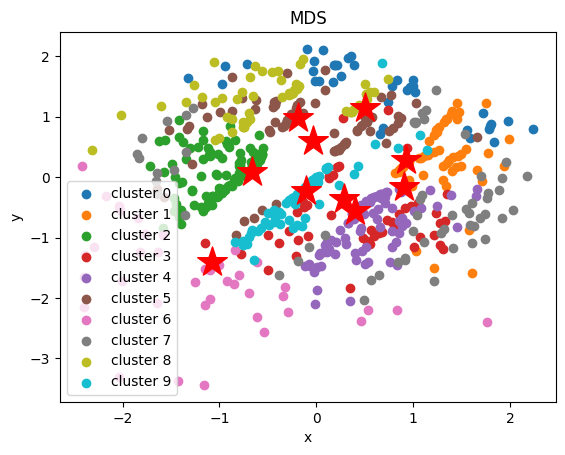

In [237]:
k = best_k_silhouette

# Create labels for the clusters
clustered_data_sklearn = cluster.KMeans(n_clusters=k, n_init=10, max_iter=300).fit(data)
df['cluster'] = labels = clustered_data_sklearn.labels_


data_and_centers = np.r_[data,clustered_data_sklearn.cluster_centers_]
XYcoordinates = manifold.MDS(n_components=2, normalized_stress="auto").fit_transform(data_and_centers)
print("transformation complete")
clustering_scatterplot(points=XYcoordinates[:-k,:], 
                       labels=labels, 
                       centers=XYcoordinates[-k:,:], 
                       title='MDS')

## Cluster plot using t-SNE with k found with silhouette score

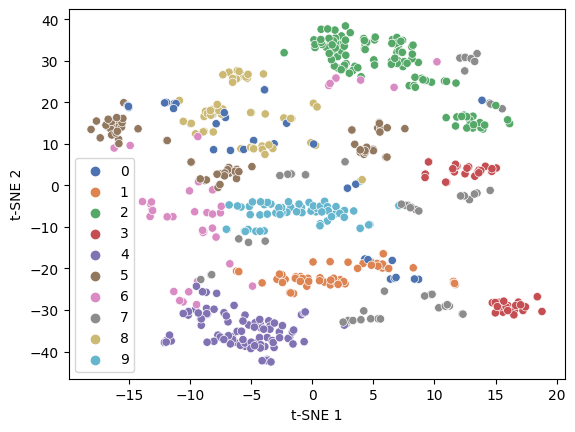

In [238]:
# Compute the t-SNE embedding
tsne = manifold.TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(df.drop(['Loan_Status_Y', 'cluster'], axis=1))

# Create a scatter plot of the data points with different colors for each cluster
sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=clustered_data_sklearn.labels_, palette='deep')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.show()


## Cluster plot using PCA with k found with silhouette score


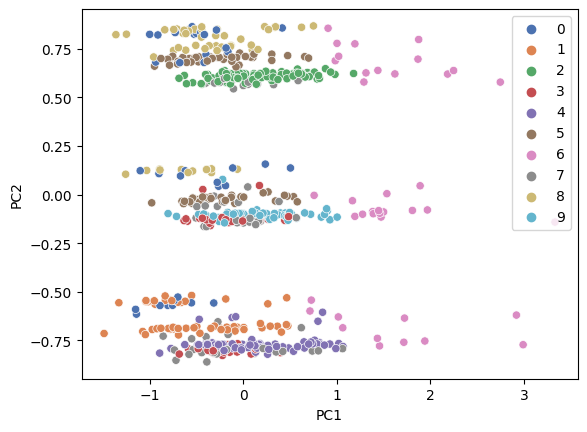

In [239]:
# Compute the first two principal components
pca = PCA(n_components=2)
pca.fit(df.drop(['Loan_Status_Y', 'cluster'], axis=1))
X_pca = pca.transform(df.drop(['Loan_Status_Y', 'cluster'], axis=1))

# Create a scatter plot of the data points with different colors for each cluster
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=clustered_data_sklearn.labels_, palette='deep')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()


## Conclusions

Using two different methods to calculate the best k we get two different value.
For Silhouette score, best k is 7.
However, when we use different methods to plot the clusters, t-SNE show the presence of clustering but it's with PCA that it's clear there are three distinc clusters in the data.

In the PCA plot, the first principal component (PC1) separates the clusters along the 'TotalIncome' and 'ApplicantIncome' axes, while the second principal component (PC2) separates the clusters along the 'LoanAmount' and 'Dependents' axes.


# Task 3

## Use Agglomerative Clustering

In [240]:
df = pd.read_csv("./loans_train_prepared-1.csv")
data = np.array(df.values, dtype=float)
print('(number of examples, number of attributes): ', data.shape)

(number of examples, number of attributes):  (614, 16)


In [241]:
agg_clustering = cluster.AgglomerativeClustering(n_clusters=3, linkage='ward')
agg_clustering.fit(df.drop(['Loan_Status_Y'], axis=1))

# Add the cluster labels to the dataset
df['cluster'] = agg_clustering.labels_


In [242]:
# Compute the Calinski-Harabasz index for different values of k
def calculate_calinski_harabasz_score(data, k):
    agg_clustering = cluster.AgglomerativeClustering(n_clusters=k, linkage='ward')
    agg_clustering.fit(df.drop(['Loan_Status_Y'], axis=1))
    return calinski_harabasz_score(df.drop(['Loan_Status_Y'], axis=1), agg_clustering.labels_)

max_k = 10
k_values = range(2, max_k+1)
calinski_harabasz_scores = [calculate_calinski_harabasz_score(data, k) for k in k_values]


plt.plot(k_values, calinski_harabasz_scores, 'bo-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Calinski Harabasz Scores')
plt.title('Elbow method for best k')
plt.show()


In [243]:
best_k_calinski_harabasz = k_values[1:][np.argmax(calinski_harabasz_scores)]

print("Best k value using Calinski Harabasz score: ", best_k_calinski_harabasz)



Best k value using Calinski Harabasz score:  3


## Cluster plot using t-SNE with k found with Calinski Harabasz

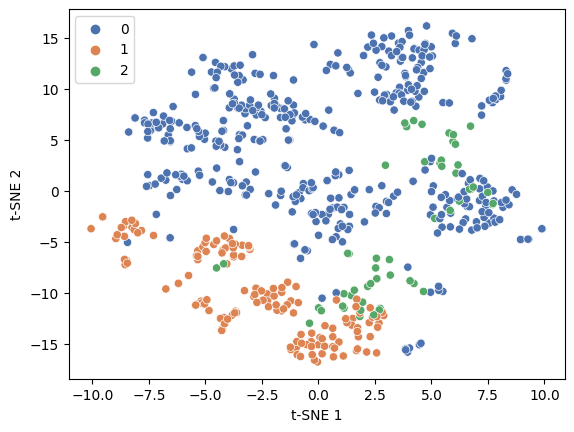

In [244]:
k = best_k_calinski_harabasz

# Compute the t-SNE embedding
tsne = manifold.TSNE(n_components=k)
X_tsne = tsne.fit_transform(df.drop(['Loan_Status_Y', 'cluster'], axis=1))

# Create a scatter plot of the data points with different colors for each cluster
sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=agg_clustering.labels_, palette='deep')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.show()


## Cluster plot using PCA with k found with silhouette score


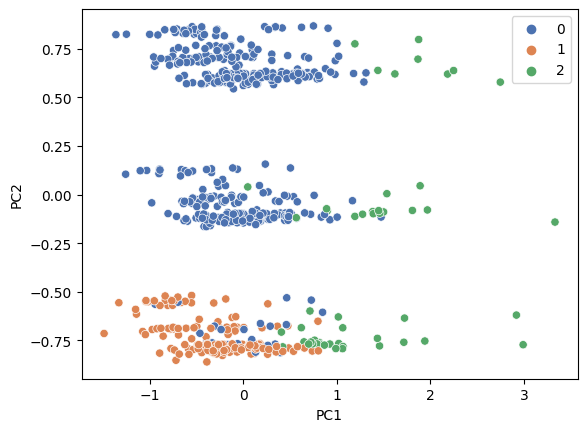

In [245]:
# Compute the first two principal components
pca = PCA(n_components=2)
pca.fit(df.drop(['Loan_Status_Y', 'cluster'], axis=1))
X_pca = pca.transform(df.drop(['Loan_Status_Y', 'cluster'], axis=1))

# Create a scatter plot of the data points with different colors for each cluster
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=agg_clustering.labels_, palette='deep')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()


## Conclusions
Using the Agglomerative Clustering method, together with Calinski Harabasz Score, gives a best k value of 3.
However, while it's still clear there are 3 clear cluster, none of the plotting method actually gives a good representation.